In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt 

In [2]:
class VideoProcessor:
    def __init__(self, 
                 modelFile="../models/res10_300x300_ssd_iter_140000.caffemodel",
                 configFile = "../models/deploy.prototxt",
                 max_interations = 20,
                 conf_threshold = 0.60,
                 nframesdiff = 5,
                 normalized_dim = 128):
        self.modelFile = modelFile
        self.configFile = configFile
        self.max_interations = max_interations
        self.conf_threshold = conf_threshold
        self.nframesdiff = nframesdiff
        self.normalized_dim = normalized_dim
        self.net = cv2.dnn.readNetFromCaffe(self.configFile, self.modelFile)
        self.mean = 128

    def extract_face(self, img):
        (h, w) = img.shape[:2]
        face = None
        blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0, (300, 300), (103.93, 116.77, 123.68))
        self.net.setInput(blob)
        detections = self.net.forward()
        for i in range(detections.shape[2]):
            if detections[0, 0, i, 2] > self.conf_threshold:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (x1, y1, x2, y2) = box.astype("int")
                face = img[y1:y2, x1:x2]
                face = cv2.resize(face, (self.normalized_dim,self.normalized_dim))
                break
                    
        return face

    def extract_random_sequence(self, filename, num_frames=16, frame_ini=100):
        captured_seq = np.empty(shape=(0,self.normalized_dim,self.normalized_dim,3), dtype=np.int8)
        iterations = 0
        frame = -1
        v_cap = cv2.VideoCapture(filename)
        v_length = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        while len(captured_seq) < num_frames and iterations < self.max_interations:
            iterations += 1
            if frame == -1:
                frame = frame_ini
                v_cap.set(1, frame)

            ret, img = v_cap.read()
            
            if ret == True:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                face = self.extract_face(img)
                if face is not None:
                    captured_seq = np.append(captured_seq,[face],axis=0)

        
        v_cap.release()
        cv2.destroyAllWindows() 
        
        captured_seq = (captured_seq / 255.).astype(np.float32)

        return captured_seq

        

In [43]:
df = pd.DataFrame()
for root, dirs, files in os.walk('../videos', topdown=False):
    for name in dirs:
        print(name)
        dfdir = pd.read_json('../videos/' + name + '/metadata.json')
        dfdir = dfdir.T
        dfdir['dir'] = name
        df = df.append(dfdir)
df["processed"] = 'False'

df.to_csv('../data/metadata_lstm1.csv',index_label='video')

dfdc_train_part_1
dfdc_train_part_14
dfdc_train_part_48
dfdc_train_part_3
dfdc_train_part_2


### Prepare Data

In [3]:
df = pd.read_csv('../data/metadata_lstm1.csv')

In [10]:
df.query('label=="FAKE" and processed == "train_lstm1_1"').sample(10)

,video,label,original,split,dir,processed
6788,gurzpxkvrb.mp4,FAKE,pxrhjlzird.mp4,train,dfdc_train_part_3,train_lstm1_1
1748,zduotrufji.mp4,FAKE,ylbdflgawa.mp4,train,dfdc_train_part_14,train_lstm1_1
5408,mvjovkcfql.mp4,FAKE,famavifufv.mp4,train,dfdc_train_part_48,train_lstm1_1
8830,kpbxapzamz.mp4,FAKE,bfjsthfhbd.mp4,train,dfdc_train_part_2,train_lstm1_1
2830,nwgbsdkryv.mp4,FAKE,evelnossix.mp4,train,dfdc_train_part_14,train_lstm1_1
2586,zahivgfcll.mp4,FAKE,zeqjgtjmxm.mp4,train,dfdc_train_part_14,train_lstm1_1
5605,ojmzeaywwf.mp4,FAKE,hbouvodtjy.mp4,train,dfdc_train_part_48,train_lstm1_1
3832,hnelbkvbxf.mp4,FAKE,ijnfpkuhcm.mp4,train,dfdc_train_part_14,train_lstm1_1
7532,wtsstxpita.mp4,FAKE,gcjtyaqiwo.mp4,train,dfdc_train_part_3,train_lstm1_1
6253,ofouaavqrm.mp4,FAKE,irdptfgpbb.mp4,train,dfdc_train_part_48,train_lstm1_1


  0%|          | 0/1 [00:00<?, ?it/s]

num. diff =  16 / 16


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


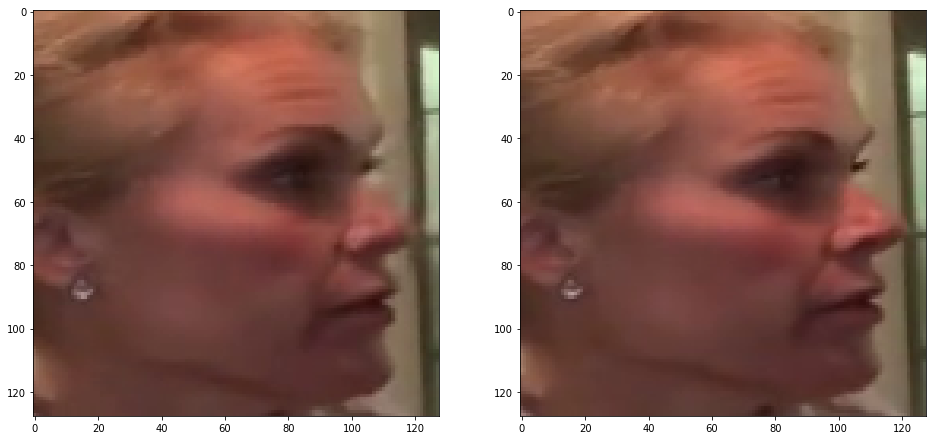

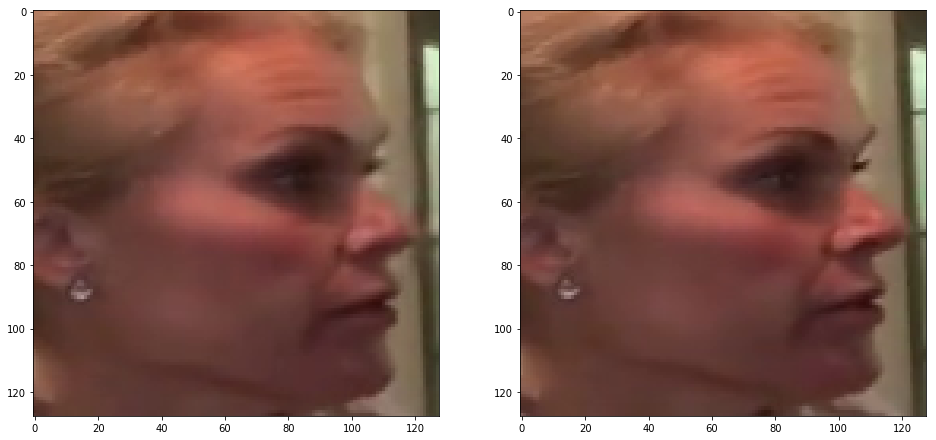

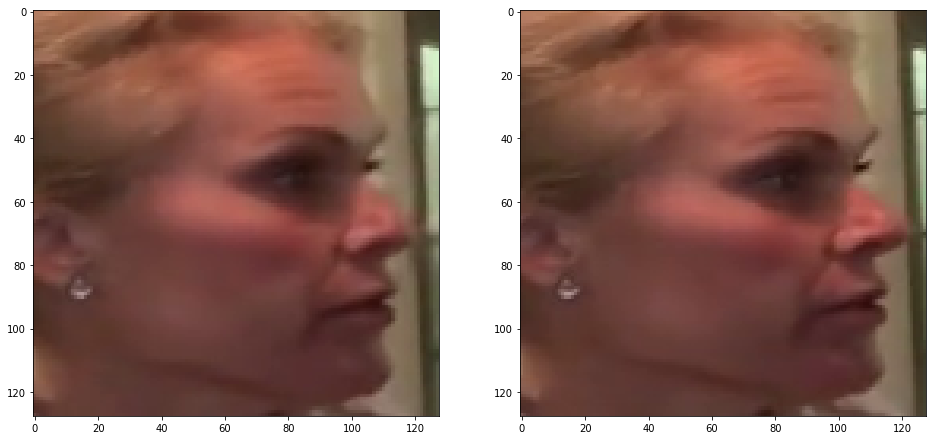

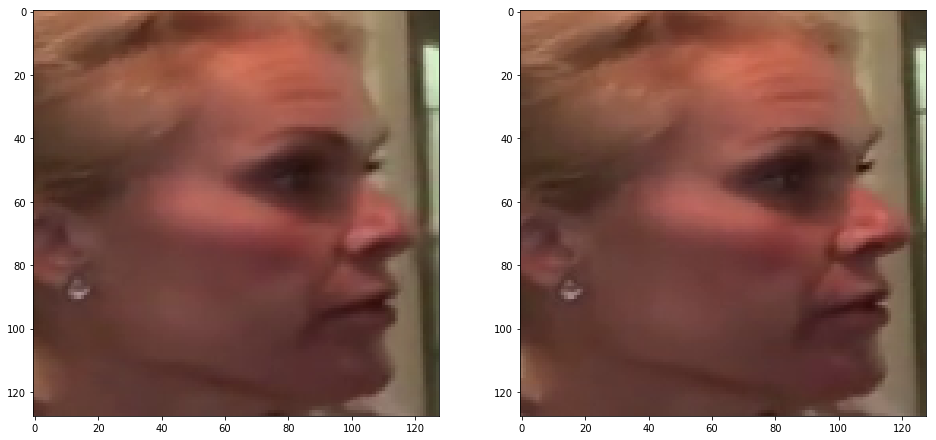

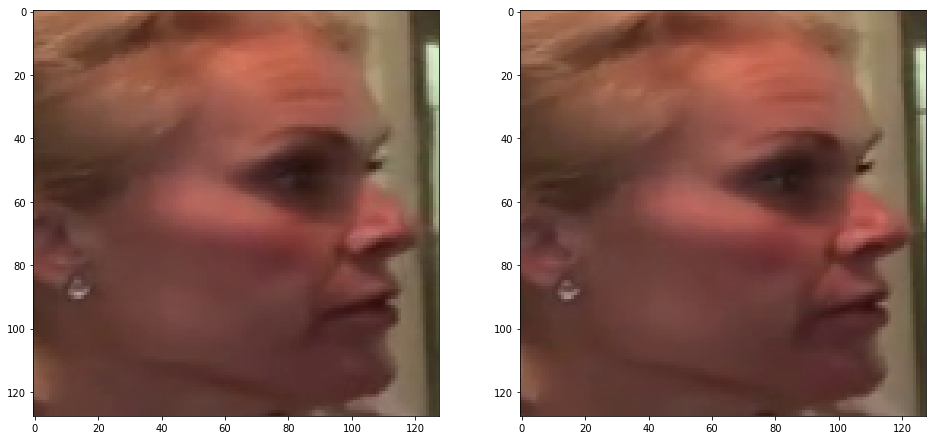

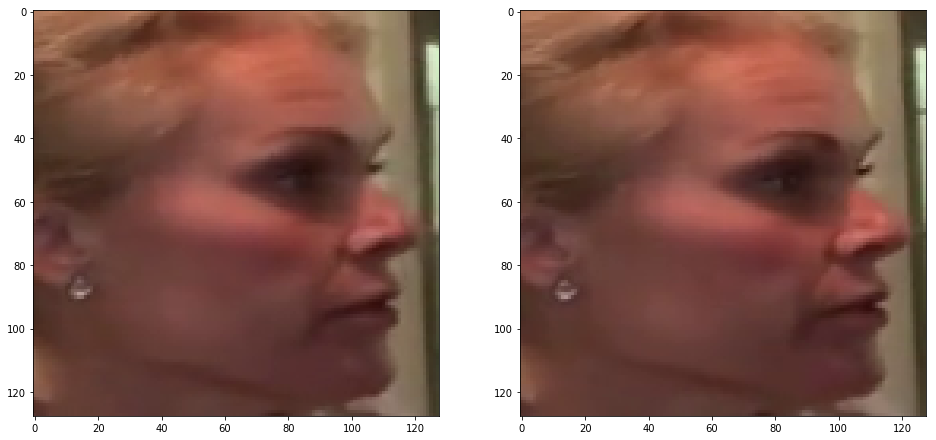

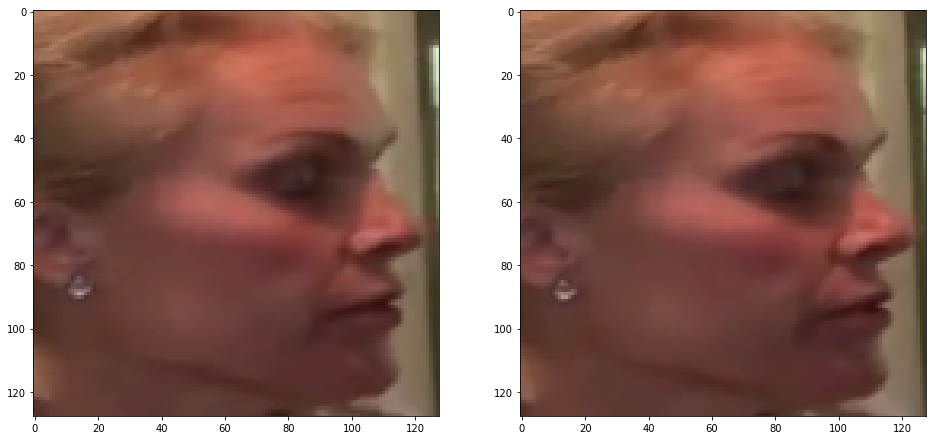

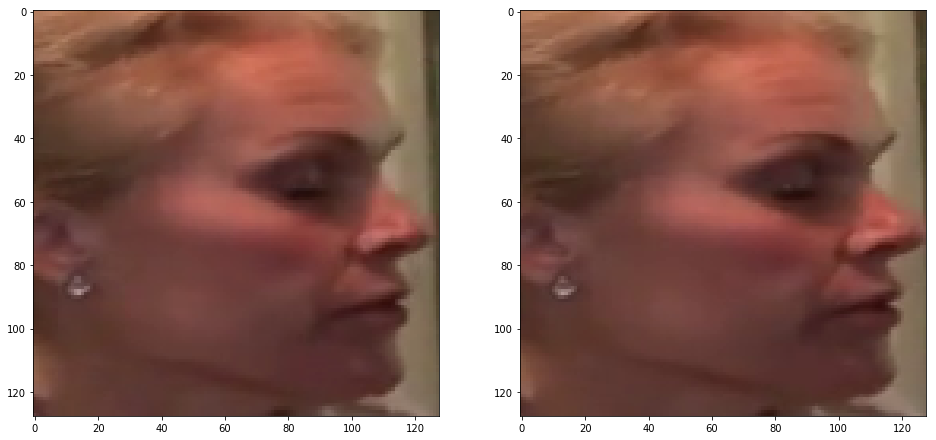

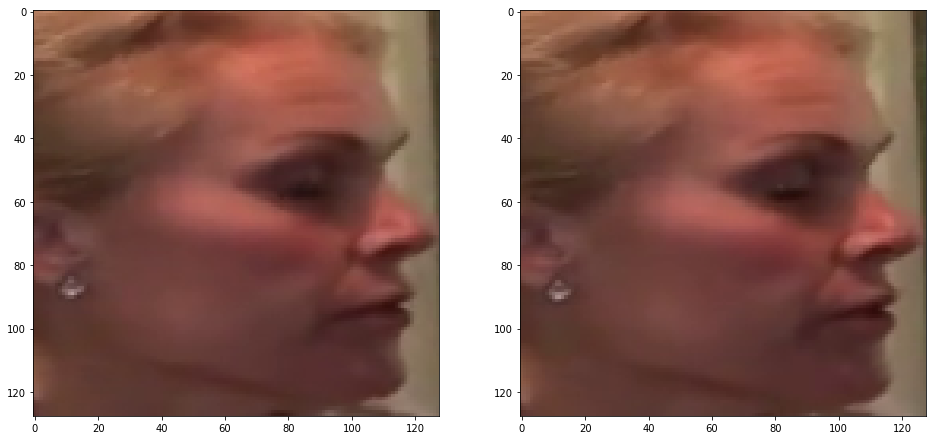

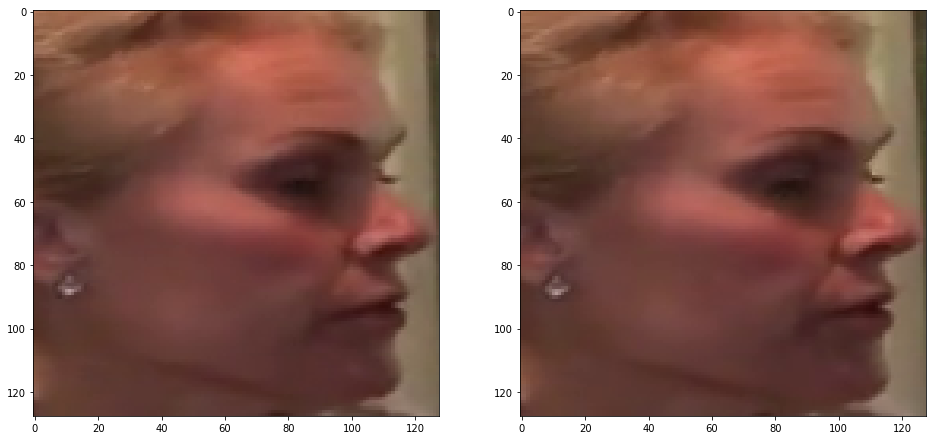

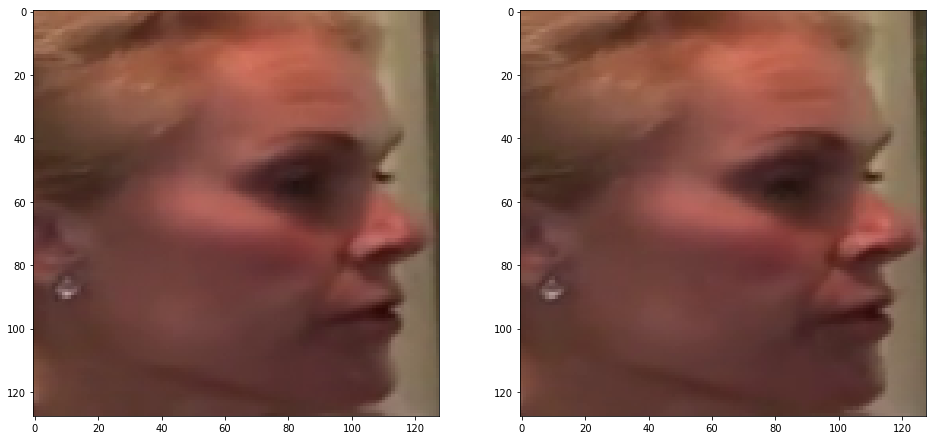

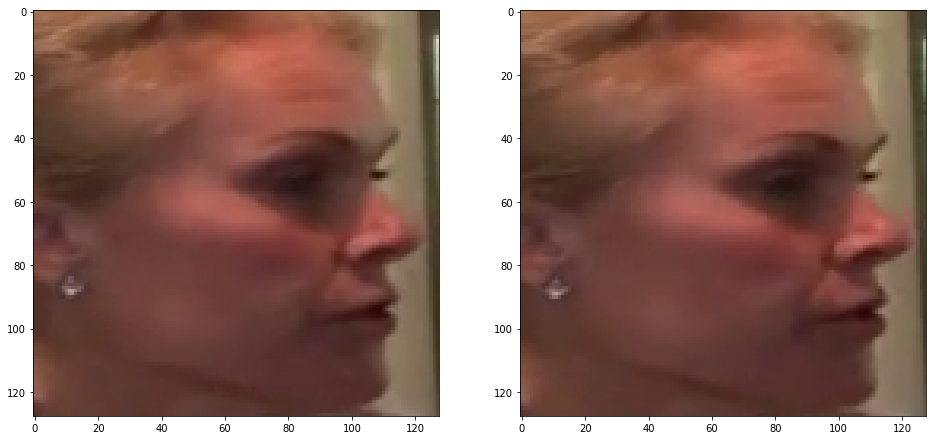

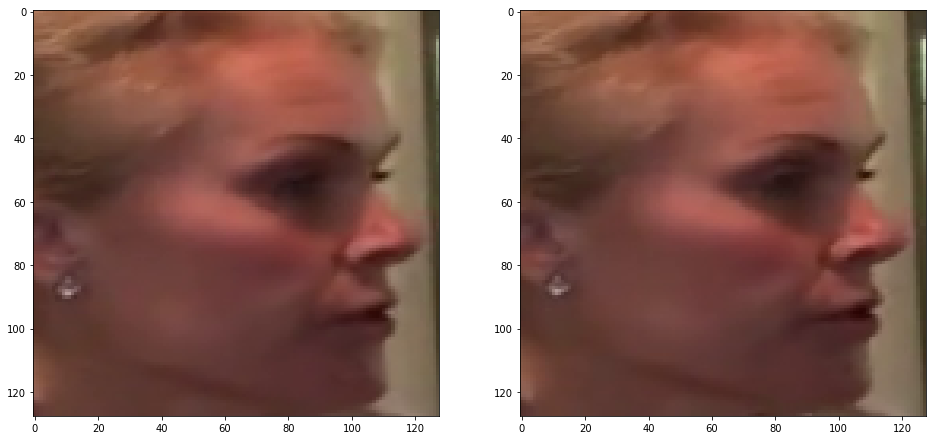

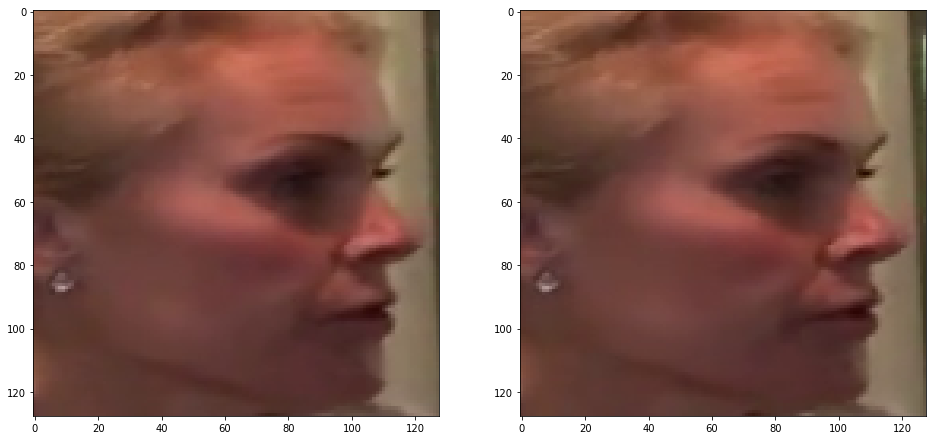

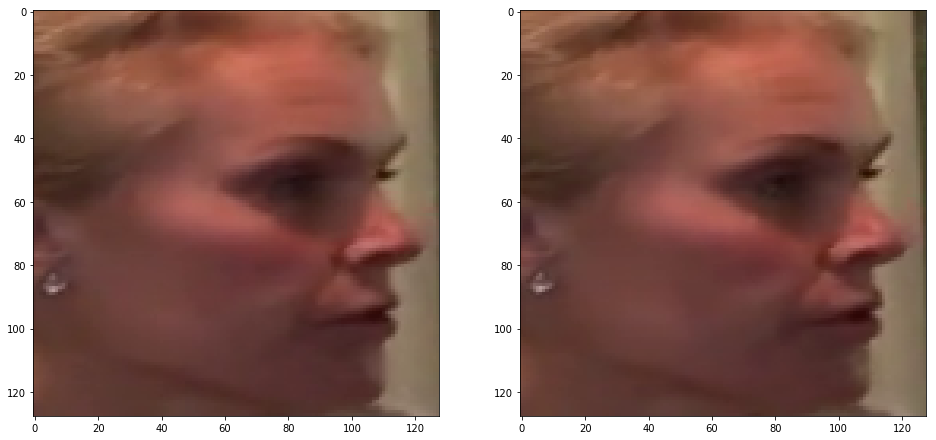

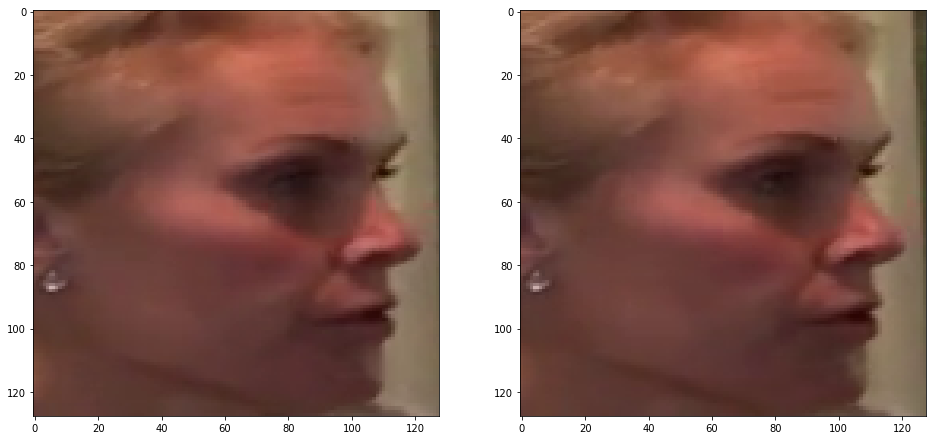

In [42]:
vp = VideoProcessor()

for index, row in tqdm(df.query('label=="FAKE"').sample().iterrows(), total=1):
    fakes = vp.extract_random_sequence('../videos/' + row.dir + '/' + row.video)
    reals = vp.extract_random_sequence('../videos/' + row.dir + '/' + row.original)
    print(f"num. diff = ", len(fakes), "/" , len(reals))
    for (imgf, imgr) in zip(fakes,reals):
        fig, (axf,axr) = plt.subplots(1,2, figsize=(16,8))
        axf.imshow(imgf)
        axr.imshow(imgr)


In [12]:
batch = 10
nsample = 32
d = 128

vp = VideoProcessor()

while True:
    sample = df.query('label=="FAKE" and processed == "False"').sample(nsample)
    if len(sample) == 0:
        break

    fakes = np.empty(shape=(0,16,d,d,3), dtype=np.int8)
    reals = np.empty(shape=(0,16,d,d,3), dtype=np.int8)

    batch += 1
    for index, row in tqdm(sample.iterrows(), total=nsample):
        seq_fakes = vp.extract_random_sequence('../videos/' + row.dir + '/' + row.video)
        if len(seq_fakes) == 16:
            fakes = np.append(fakes,np.expand_dims(seq_fakes, axis=0),axis=0)
        seq_reals = vp.extract_random_sequence('../videos/' + row.dir + '/' + row.original)
        if len(seq_reals) == 16:
            reals = np.append(reals,np.expand_dims(seq_reals, axis=0),axis=0)

    np.savez(f'../data/train_lstm1_{batch}', fakes=fakes, reals=reals)
    df.loc[sample.index,'processed'] = f'train_lstm1_{batch}'
    df.to_csv('../data/metadata_lstm1.csv',index = False)
    print(f'saved batch: {batch}')

  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 11


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 12


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 13


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 14


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 15


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 16


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 17


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 18


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 19


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 20


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 21


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 22


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 23


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 24


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 25


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 26


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 27


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 28


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 29


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 30


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 31


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 32


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 33


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 34


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 35


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 36


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 37


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 38


  0%|          | 0/32 [00:00<?, ?it/s]

saved batch: 39


  6%|▋         | 2/32 [00:03<00:50,  1.68s/it]


KeyboardInterrupt: 

In [26]:
fakes.shape

(16, 128, 128, 3)